In [1]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 152.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2


In [4]:
# 1. INSTALL LIBRARIES
!pip install soundata transformers librosa scikit-learn torch

# 2. IMPORTS & SETUP
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import soundata
import os
import random
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, confusion_matrix, roc_auc_score
from transformers import ASTFeatureExtractor, ASTForAudioClassification
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

# Set Device & Seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

def set_seeds(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seeds()

Using Device: cuda


In [5]:
# 1. DOWNLOAD & PREPARE DATASET
print('Initializing UrbanSound8K Dataset')
urbansound8k = soundata.initialize('urbansound8k')
if not os.path.exists(urbansound8k.data_home):
    print('Downloading Dataset')
    urbansound8k.download()
    urbansound8k.validate()

# Create Metadata DataFrame
clip_ids = urbansound8k.clip_ids
metadata_list = []
for clip_id in clip_ids:
    clip = urbansound8k.clip(clip_id)
    metadata_list.append({
        'slice_file_name': clip_id,
        'fold': clip.fold,
        'class': clip.tags.labels[0] if clip.tags.labels else 'unknown',
    })
metadata = pd.DataFrame(metadata_list)
print(f"Dataset Ready: {len(metadata)} samples")

# 2. DEFINE AUGMENTATION FUNCTION
def augment_audio(y, sr, p=0.5):
    """
    Applies random augmentations to the audio waveform.
    p: probability of applying each augmentation
    """
    y_aug = y.copy()

    # Time Stretching
    if random.random() < p:
        rate = np.random.uniform(0.8, 1.2)
        y_aug = librosa.effects.time_stretch(y_aug, rate=rate)

    # Pitch Shifting
    if random.random() < p:
        steps = np.random.randint(-2, 3)
        y_aug = librosa.effects.pitch_shift(y_aug, sr=sr, n_steps=steps)

    # Background Noise Injection
    if random.random() < p:
        noise_amp = 0.005 * np.random.uniform() * np.amax(y_aug)
        y_aug = y_aug + noise_amp * np.random.normal(size=y_aug.shape[0])

    return y_aug

# 3. EXTRACT FEATURES (AST)
print("\nPre-computing AST inputs with Augmentation...")
feature_extractor = ASTFeatureExtractor.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    max_length=1024,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

inputs = []
labels = []

print("Processing audio clips")
for idx, row in tqdm(metadata.iterrows(), total=len(metadata)):
    clip = urbansound8k.clip(row['slice_file_name'])
    y, sr = clip.audio

    # Resample to 16kHz
    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)

    # Apply Augmentation
    y = augment_audio(y, sr=16000, p=0.4)

    # Extract Spectrogram
    encoded = feature_extractor(y, sampling_rate=16000, return_tensors="pt")
    inputs.append(encoded['input_values'])
    labels.append(row['class'])

# 4. STACK AND MOVE TO GPU
X_ast = torch.cat(inputs, dim=0)
print(f"\nCorrected AST Input Shape: {X_ast.shape}")

le = LabelEncoder()
y_ast_numpy = le.fit_transform(labels)
y_ast = torch.tensor(y_ast_numpy, dtype=torch.long)

X_ast = X_ast.to(device)
y_ast = y_ast.to(device)
print("Data moved to GPU!")

Initializing UrbanSound8K Dataset
Dataset Ready: 8732 samples

Pre-computing AST inputs with Augmentation...
Processing audio clips


  6%|▌         | 494/8732 [00:14<03:55, 35.03it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=860
  warnings.warn(
  6%|▋         | 565/8732 [00:16<03:50, 35.43it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1105
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1008
  warnings.warn(
  8%|▊         | 708/8732 [00:20<03:15, 41.06it/s]/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=960
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: Use


Corrected AST Input Shape: torch.Size([8732, 1024, 128])
Data moved to GPU!


In [6]:
# PART 1: TRAINING

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from transformers import ASTForAudioClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef

# 1. HELPER CLASSES
class ModelEvaluator:
    def __init__(self, class_names):
        self.class_names = class_names

    def compute_metrics(self, y_true, y_pred, y_proba=None):
        metrics = {}
        metrics['accuracy'] = accuracy_score(y_true, y_pred)
        p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=0)
        metrics['precision'] = p
        metrics['recall'] = r
        metrics['f1_score'] = f1
        metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
        return metrics

def aggregate_metrics(fold_metrics):
    avg_metrics = {}
    # We now aggregate ALL these metrics
    for metric in ['accuracy', 'f1_score', 'mcc', 'precision', 'recall']:
        values = [fm[metric] for fm in fold_metrics]
        avg_metrics[f'{metric}_mean'] = np.mean(values)
        avg_metrics[f'{metric}_std'] = np.std(values)
    return avg_metrics

def print_average_metrics(avg_metrics):
    print("\nAVERAGE METRICS ACROSS 10 FOLDS")
    print(f"Accuracy:  {avg_metrics['accuracy_mean']:.4f} (+/- {avg_metrics['accuracy_std']:.4f})")
    print(f"Precision: {avg_metrics['precision_mean']:.4f}")
    print(f"Recall:    {avg_metrics['recall_mean']:.4f}")
    print(f"F1 Score:  {avg_metrics['f1_score_mean']:.4f}")
    print(f"MCC:       {avg_metrics['mcc_mean']:.4f}")

# 2. TRAINING FUNCTION
def cross_validate_ast(metadata, X_all, y_all, epochs=5, batch_size=16):
    print(f'\nStarting AST Cross Validation.')

    label_encoder = LabelEncoder()
    label_encoder.fit(metadata['class'])
    class_names = label_encoder.classes_
    evaluator = ModelEvaluator(class_names)
    scaler = GradScaler()

    # Storage for final aggregation
    fold_metrics = []
    all_y_true = []
    all_y_pred = []
    all_y_probs = [] # Needed for ROC

    for fold in range(1, 11):
        print(f'Fold {fold}...', end=' ')

        # Slicing
        train_idx = torch.tensor(metadata[metadata['fold'] != fold].index.values)
        test_idx = torch.tensor(metadata[metadata['fold'] == fold].index.values)

        if X_all.is_cuda:
            X_train, y_train = X_all[train_idx], y_all[train_idx]
            X_test, y_test = X_all[test_idx], y_all[test_idx]
        else:
            X_train, y_train = X_all[train_idx], y_all[train_idx]
            X_test, y_test = X_all[test_idx], y_all[test_idx]

        # Initialize Model
        model = ASTForAudioClassification.from_pretrained(
            "MIT/ast-finetuned-audioset-10-10-0.4593",
            num_labels=len(class_names),
            ignore_mismatched_sizes=True
        ).to(device)

        optimizer = optim.AdamW(model.parameters(), lr=1e-5)
        criterion = nn.CrossEntropyLoss()

        # Train Loop
        model.train()
        num_samples = X_train.shape[0]

        for epoch in range(epochs):
            perm = torch.randperm(num_samples, device=device if X_train.is_cuda else 'cpu')
            for i in range(0, num_samples, batch_size):
                indices = perm[i : i + batch_size]
                batch_X = X_train[indices]
                batch_y = y_train[indices]

                if not batch_X.is_cuda:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(batch_X).logits
                    loss = criterion(outputs, batch_y)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # Eval Loop
        model.eval()
        with torch.no_grad():
            fold_preds = []
            fold_probs = []

            for i in range(0, X_test.shape[0], batch_size):
                batch_X = X_test[i : i + batch_size]
                if not batch_X.is_cuda:
                    batch_X = batch_X.to(device)

                outputs = model(batch_X).logits

                # Predictions
                preds = torch.max(outputs, 1)[1]
                fold_preds.extend(preds.cpu().numpy())

                # Probabilities (for ROC)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                fold_probs.extend(probs.cpu().numpy())

            y_test_cpu = y_test.cpu().numpy()

            # STORE GLOBAL DATA
            all_y_true.extend(y_test_cpu)
            all_y_pred.extend(fold_preds)
            all_y_probs.extend(fold_probs)

        metrics = evaluator.compute_metrics(np.array(y_test_cpu), np.array(fold_preds))
        fold_metrics.append(metrics)
        print(f"Acc: {metrics['accuracy']:.4f}")

    avg_metrics = aggregate_metrics(fold_metrics)
    print_average_metrics(avg_metrics)

    return np.array(all_y_true), np.array(all_y_pred), np.array(all_y_probs), avg_metrics

# 3. RUN THE TRAINING
print("Running Cross-Validation")
y_true_all, y_pred_all, y_probs_all, ast_avg = cross_validate_ast(metadata, X_ast, y_ast, epochs=5, batch_size=32)

Running Cross-Validation

Starting AST Cross Validation.
Fold 1... 

/tmp/ipython-input-3559071978.py:53: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8499
Fold 2... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8795
Fold 3... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8000
Fold 4... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8576
Fold 5... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9177
Fold 6... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8627
Fold 7... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9117
Fold 8... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8226
Fold 9... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.9020
Fold 10... 

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3559071978.py:101: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Acc: 0.8889

AVERAGE METRICS ACROSS 10 FOLDS
Accuracy:  0.8693 (+/- 0.0364)
Precision: 0.8750
Recall:    0.8693
F1 Score:  0.8674
MCC:       0.8544


/tmp/ipython-input-1320655177.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Class', data=acc_df, palette='viridis', ax=ax4)


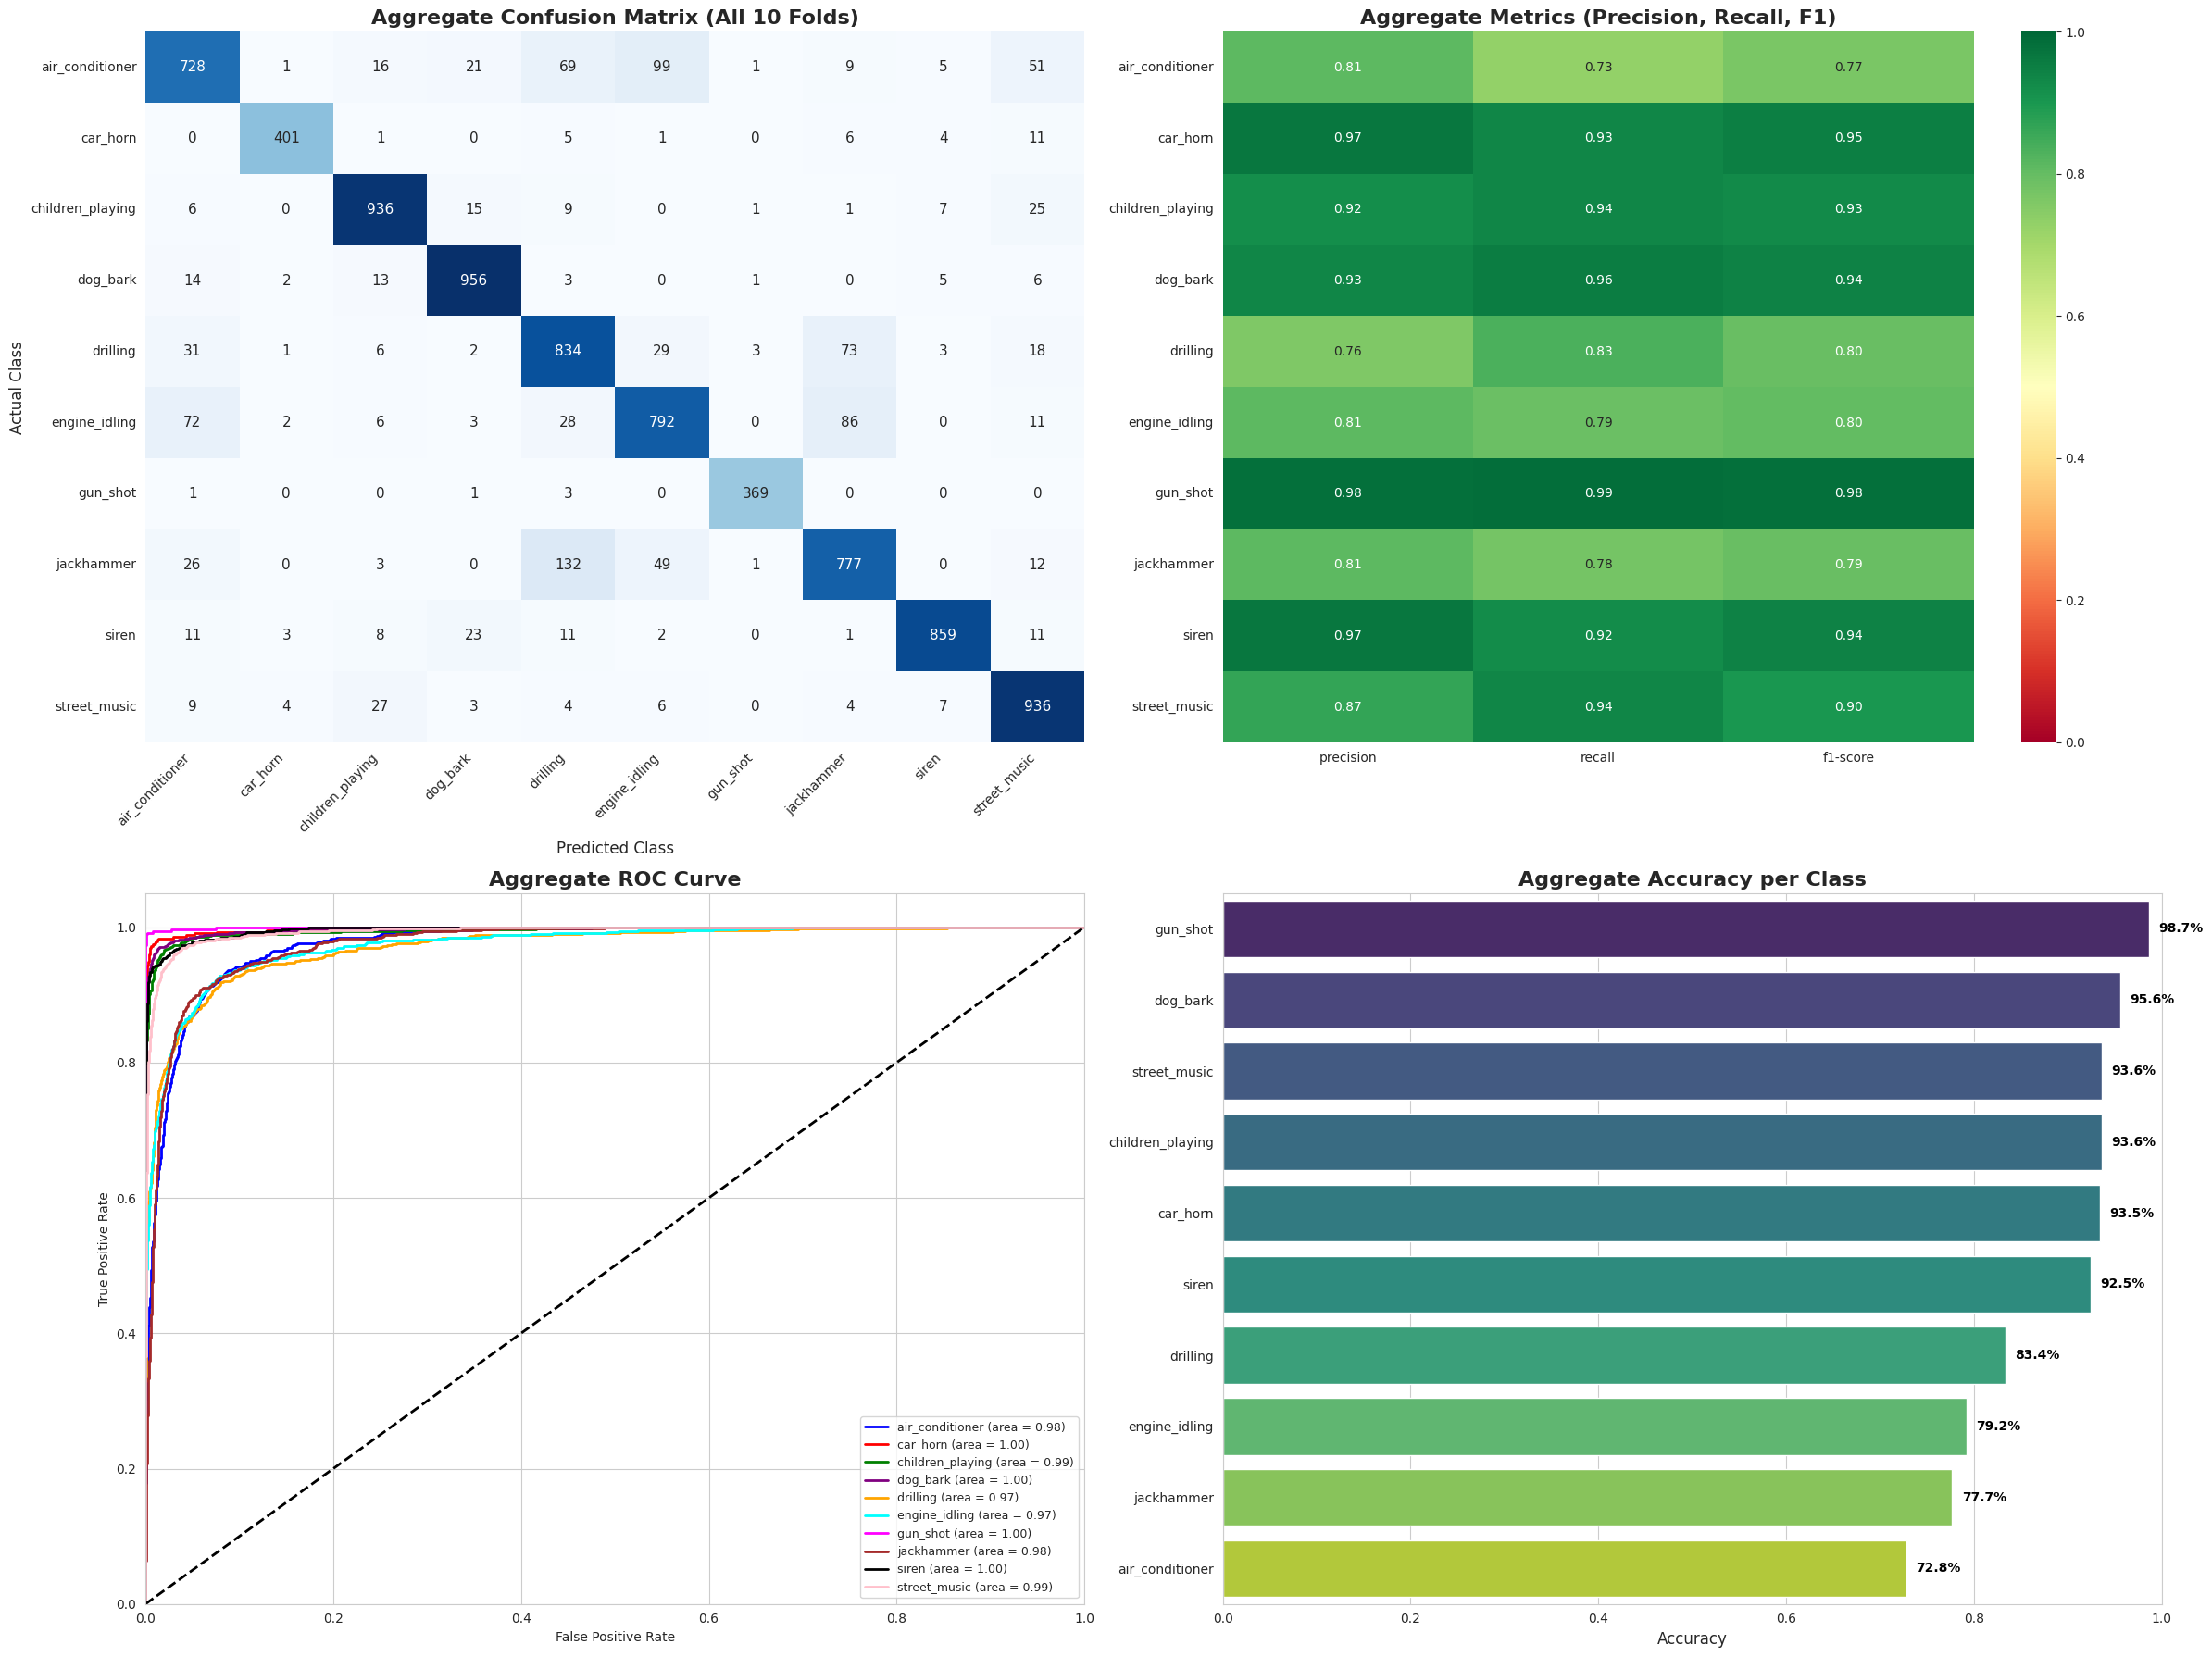


Overall Aggregate Accuracy: 86.90%


In [7]:
# VISUALIZATION

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 1. SETUP LABELS
le = LabelEncoder()
le.fit(metadata['class'])
class_names = le.classes_
n_classes = len(class_names)

# 2. GENERATE PLOTS
sns.set_style("whitegrid")
fig = plt.figure(figsize=(24, 18))

# PLOT A: CONFUSION MATRIX
ax1 = plt.subplot(2, 2, 1)
cm = confusion_matrix(y_true_all, y_pred_all)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names, ax=ax1, annot_kws={"size": 11})
ax1.set_title('Aggregate Confusion Matrix (All 10 Folds)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Actual Class', fontsize=12)
ax1.set_xlabel('Predicted Class', fontsize=12)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# PLOT B: CLASSIFICATION REPORT HEATMAP
ax2 = plt.subplot(2, 2, 2)
clf_report = classification_report(y_true_all, y_pred_all, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(clf_report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap="RdYlGn", fmt=".2f", vmin=0.0, vmax=1.0, ax=ax2)
ax2.set_title('Aggregate Metrics (Precision, Recall, F1)', fontsize=16, fontweight='bold')
ax2.set_yticks(np.arange(len(report_df))+0.5)
ax2.set_yticklabels(report_df.index, rotation=0)

# PLOT C: MULTI-CLASS ROC CURVE
ax3 = plt.subplot(2, 2, 3)
# Binarize labels for ROC
y_test_bin = label_binarize(y_true_all, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'brown', 'black', 'pink'])
for i, color in zip(range(n_classes), colors):
    ax3.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

ax3.plot([0, 1], [0, 1], 'k--', lw=2)
ax3.set_xlim([0.0, 1.0])
ax3.set_ylim([0.0, 1.05])
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('Aggregate ROC Curve', fontsize=16, fontweight='bold')
ax3.legend(loc="lower right", fontsize=9)

# PLOT D: CLASS-WISE ACCURACY BAR CHART
ax4 = plt.subplot(2, 2, 4)
# Calculate accuracy per class manually from Confusion Matrix
class_accuracies = cm.diagonal() / cm.sum(axis=1)
acc_df = pd.DataFrame({'Class': class_names, 'Accuracy': class_accuracies})
acc_df = acc_df.sort_values('Accuracy', ascending=False)

sns.barplot(x='Accuracy', y='Class', data=acc_df, palette='viridis', ax=ax4)
ax4.set_xlim(0, 1.0)
ax4.set_title('Aggregate Accuracy per Class', fontsize=16, fontweight='bold')
ax4.set_xlabel('Accuracy', fontsize=12)
ax4.set_ylabel('')

# Add percentage labels
for i, v in enumerate(acc_df['Accuracy']):
    ax4.text(v + 0.01, i, f"{v*100:.1f}%", color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nOverall Aggregate Accuracy: {np.mean(y_true_all == y_pred_all)*100:.2f}%")

Calculating t-SNE and Confidence metrics
Ready to plot.


/tmp/ipython-input-1743606703.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Confidence", y="True Class", data=df_viz, palette="viridis", ax=ax2, inner="quartile")


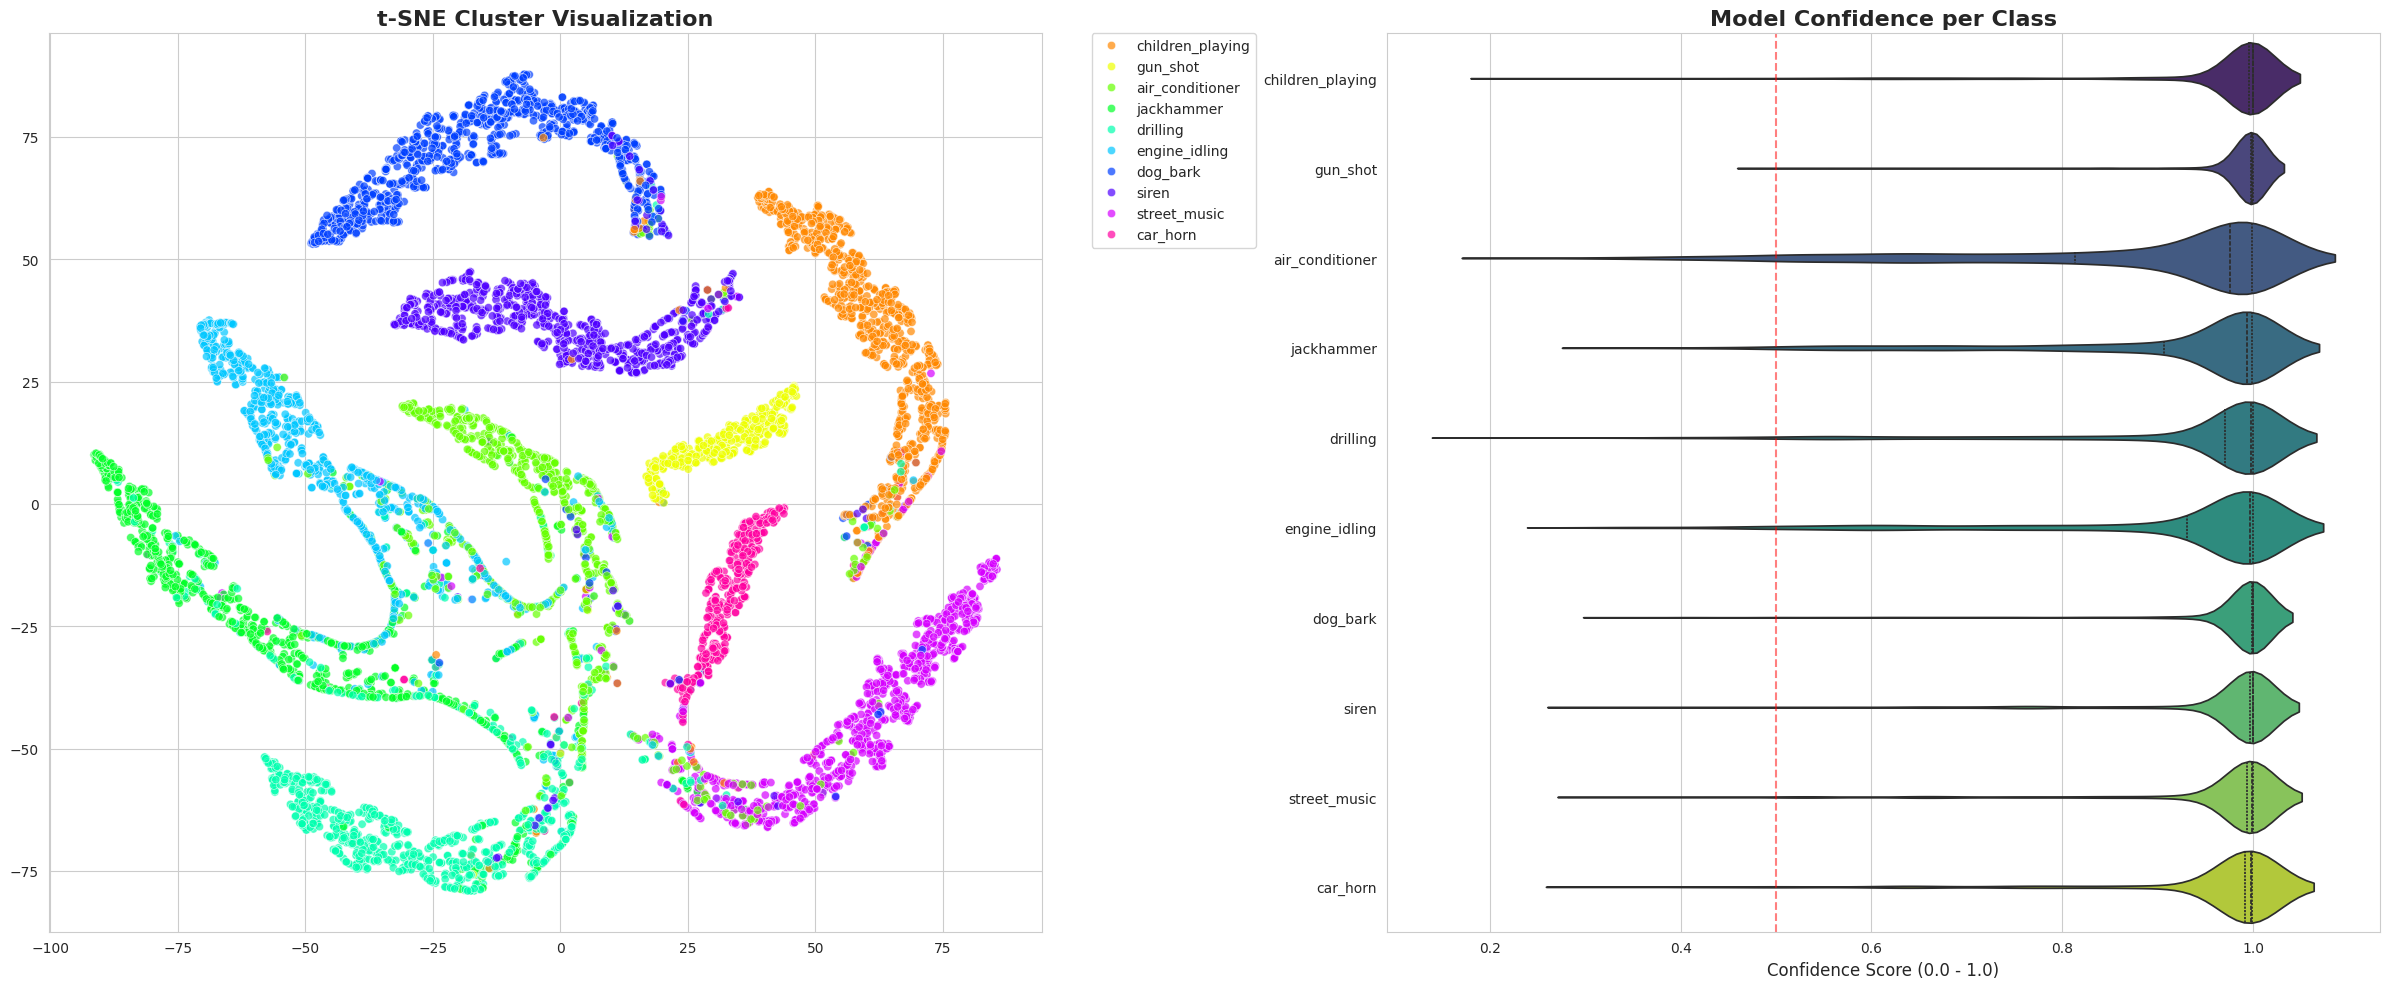

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE

# 1. SETUP DATA FOR PLOTTING
print("Calculating t-SNE and Confidence metrics")

# Create a DataFrame for easy plotting
df_viz = pd.DataFrame({
    'True Class': [class_names[i] for i in y_true_all],
    'Predicted Class': [class_names[i] for i in y_pred_all],
    'Confidence': np.max(y_probs_all, axis=1), # Take the probability of the predicted class
    'Correct': y_true_all == y_pred_all
})

# 2. RUN t-SNE (Dimensionality Reduction)
# We project the 10-class probability vector down to 2D to see clusters
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(y_probs_all)

df_viz['tsne-2d-one'] = tsne_results[:,0]
df_viz['tsne-2d-two'] = tsne_results[:,1]

print("Ready to plot.")

# 3. GENERATE PLOTS
fig = plt.figure(figsize=(24, 10))

# t-SNE CLUSTER MAP
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="True Class",
    palette=sns.color_palette("hsv", 10),
    data=df_viz,
    legend="full",
    alpha=0.7,
    ax=ax1
)
ax1.set_title('t-SNE Cluster Visualization', fontsize=16, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# CONFIDENCE DENSITY (VIOLIN PLOT)
ax2 = plt.subplot(1, 2, 2)
sns.violinplot(x="Confidence", y="True Class", data=df_viz, palette="viridis", ax=ax2, inner="quartile")
ax2.set_title('Model Confidence per Class', fontsize=16, fontweight='bold')
ax2.set_xlabel('Confidence Score (0.0 - 1.0)', fontsize=12)
ax2.set_ylabel('')
ax2.axvline(0.5, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

In [11]:
from sklearn.metrics import classification_report

# Ensure class names are available
le = LabelEncoder()
le.fit(metadata['class'])
class_names = le.classes_

print("          FULL CLASSIFICATION REPORT (AGGREGATED)")

# Generate and print the report
report = classification_report(
    y_true_all,
    y_pred_all,
    target_names=class_names,
    digits=4 # Print 4 decimal places for precision
)

print(report)

          FULL CLASSIFICATION REPORT (AGGREGATED)
                  precision    recall  f1-score   support

 air_conditioner     0.8107    0.7280    0.7671      1000
        car_horn     0.9686    0.9347    0.9514       429
children_playing     0.9213    0.9360    0.9286      1000
        dog_bark     0.9336    0.9560    0.9447      1000
        drilling     0.7596    0.8340    0.7950      1000
   engine_idling     0.8098    0.7920    0.8008      1000
        gun_shot     0.9814    0.9866    0.9840       374
      jackhammer     0.8119    0.7770    0.7941      1000
           siren     0.9652    0.9247    0.9445       929
    street_music     0.8659    0.9360    0.8996      1000

        accuracy                         0.8690      8732
       macro avg     0.8828    0.8805    0.8810      8732
    weighted avg     0.8694    0.8690    0.8685      8732

